12/03...温度なし、エラーが取れた

12/10...温度をつけた、結果の表示方法変更

In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math, warnings
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
#valiable
warnings.resetwarnings()

warnings.simplefilter('error')
num_select=1
#T=0.1
MCMC_step=10000
T=1000

In [3]:
X = pd.read_table('training_markers.txt', header=None,  sep ='\t')# 説明変数（こっちの特徴量上位5つ取り出す）


data_yields = pd.read_table('training_yields.txt', header=None,  sep ='\t')# 目的変数
y_list = []
for i in range(len(data_yields)):
    y_list.append(data_yields.iloc[i, 0])
y = pd.Series(y_list)


num_sample = X.shape[0]#サンプル数
num_feature = X.shape[1]#特徴量の数

In [4]:
type(X) #pandas.core.frame.DataFrame
X.shape #(20, 20)

type(y) #pandas.core.series.Series
y.shape #(20,)

X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,0,1,0
1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,0,1,1,0,0,1
2,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0
3,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0
4,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,0,1,1,0,1
5,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,0,0,1
6,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0
7,1,1,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,1
8,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0
9,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1


In [5]:
#特徴量の分散や同じ特徴量が存在するのかを確認

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X)

# get_supportで保持するデータのみをTrue値、そうでないものはFalse値を返します
print(sum(sel.get_support())) #20、すなわち同じ特徴量は存在していないことがわかった

20


In [6]:
y

0     1
1     0
2     0
3     1
4     1
5     0
6     0
7     1
8     0
9     1
10    0
11    0
12    1
13    0
14    0
15    0
16    1
17    1
18    1
19    1
dtype: int64

In [7]:
def selection(num_select, X, y):
    # num_select個の特徴量を選択
    #print(f_regression(X,y))
    #print(np.linalg.norm(y))
    selector = SelectKBest(score_func=f_regression, k=num_select) #SelectKBest
    selector.fit(X, y)
    mask = selector.get_support()    # 各特徴量を選択したか否かのmaskを取得
    return mask

In [8]:
"""
0-division error occurs when all values in y are 0 or 1
reason: y = y - np.mean(y), corr /= np.linalg.norm(y)
"""
mask = selection(num_select, X, y)
print(mask)

[False False False False False False False False False False False False
 False False False False False False False  True]


In [9]:
"""
def each_energy(mask, y):
    y_list = y.values.tolist()
    energy_find_dic = {}#bestな特徴量:それを選んだときのエネルギー基準値（０となる）
    for i in range(len(mask)):
        if mask[i]==True:
            energy_find_trait = np.dot(np.array(X[:][i]).T, np.array(y_list))
            energy_find_dic[i]=energy_find_trait
    return sum(energy_find_dic.values())
"""

def each_energy(mask, y):
    y_list = y.values.tolist()
    energy_trait_sum = 0
    for i in range(len(mask)):
        if mask[i]==True:
            energy_trait_sum += np.dot(np.array(X[:][i]).T, np.array(y_list))
    return energy_trait_sum

In [10]:
"""
argument: s is integer
procedure: convert s from 0 to 1 or 1 to 0
return: changed value
"""
def y_renewal(s: int):
    return 1-s

In [11]:
from sklearn.utils.extmath import safe_sparse_dot, row_norms
"""
def compute_corr(y, X):
    X_norms = 
    corr = safe_sparse_dot(y, X)
    corr /= X_norms
    X_norms_inv = np.zeros_like(X_norms)
    mask = (X_norms != 0.)
    X_norms_inv[mask] = 1. / X_norms[mask]
    corr *= X_norms_inv
    corr /= np.linalg.norm(y)#ベクトルの絶対値（原点からの距離）
    # convert to p-value
    degrees_of_freedom = y.size - (2 if center else 1)
    return corr
"""

'\ndef compute_corr(y, X):\n    X_norms = \n    corr = safe_sparse_dot(y, X)\n    corr /= X_norms\n    X_norms_inv = np.zeros_like(X_norms)\n    mask = (X_norms != 0.)\n    X_norms_inv[mask] = 1. / X_norms[mask]\n    corr *= X_norms_inv\n    corr /= np.linalg.norm(y)#ベクトルの絶対値（原点からの距離）\n    # convert to p-value\n    degrees_of_freedom = y.size - (2 if center else 1)\n    return corr\n'

In [12]:
def Montecarlo(T, num_select, MCMC_step):    
    E = []
    y_go = []
    y_list = y.values.tolist()
    
    #元のyを使って
    mask_ori = selection(num_select, X, y)
    selected_X_energy = each_energy(mask_ori, y)
    E.append(0) #selected_X_energy - selected_X_energy
    y_go.append(y_list)
    
    for j in range(MCMC_step):    
        i = random.randrange(num_sample)
        ori_yi = y[i]
        y[i] = y_renewal(y[i])
        if np.all(y == 1) or np.all(y == 0):
            continue
        mask_new = selection(num_select, X, y)
        E_now = selected_X_energy - each_energy(mask_new, y)
        E_last = E[-1]
        r = math.exp(-(E_now-E_last)/T) #温度付き
        R = np.random.uniform(0.0, 1.0)
        if R > r :
            y[i] = ori_yi #元に戻す       
        else:
            E.append(E_now)
            y_list = y.values.tolist()
            y_go.append(y_list)
    return E, y_go #エネルギーのリスト、ｙのリスト

      0  1  2  3  4  5  6  7  8  9  ...  11  12  13  14  15  16  17  18  19  \
0     1  0  0  1  1  0  0  1  0  1  ...   0   1   0   0   0   1   1   1   1   
1     1  0  0  1  1  0  1  1  0  1  ...   0   1   0   0   0   1   1   1   1   
2     0  0  0  1  1  0  1  1  0  1  ...   0   1   0   0   0   1   1   1   1   
3     0  0  0  1  1  0  1  1  1  1  ...   0   1   0   0   0   1   1   1   1   
4     0  0  0  1  1  0  1  1  1  1  ...   0   1   0   0   0   1   0   1   1   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
9991  0  0  0  1  0  0  1  1  1  0  ...   0   0   1   0   0   1   0   1   0   
9992  0  0  0  1  0  0  0  1  1  0  ...   0   0   1   0   0   1   0   1   0   
9993  0  0  0  1  0  0  0  1  1  0  ...   1   0   1   0   0   1   0   1   0   
9994  0  0  0  1  0  0  0  1  1  0  ...   1   0   1   0   0   1   1   1   0   
9995  0  0  1  1  0  0  0  1  1  0  ...   1   0   1   0   0   1   1   1   0   

      Energy  
0          0  
1          4  
2     

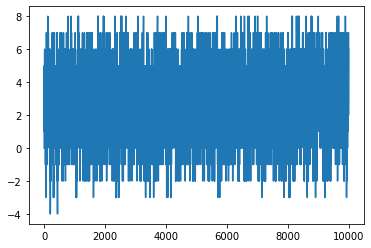

In [13]:
E, y_go = Montecarlo(T,num_select,MCMC_step)
#print(E)
#print(len(E)==len(y_go))
#print(y_go)
result_df = pd.DataFrame(y_go)
result_df['Energy'] = E
result_df.to_csv("simulated_annealing_trial1203.csv", sep=",")
print(result_df)

E_Xaxis = [i for i in range(len(E))]
plt.plot(E_Xaxis, E)
plt.show()

###  results
* yに変化なし…MCMC_step=1000, 5000, 10000のとき